# Customer Churn Prediction

### Imports

In [15]:
# Tools
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lifelines import KaplanMeierFitter, CoxPHFitter
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
from lime import lime_tabular
import seaborn as sns

In [32]:
# Dataset Loading
dataset = pd.read_csv('../dataset/dataset.csv').iloc[:, 1:]

In [33]:
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [35]:
dataset.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


### Data Cleaning

In [41]:
new_columns = [re.sub(r'(?<!^)([A-Z])', r' \1', col).title() for col in dataset.columns]
new_columns[-8] = 'Streaming TV'
dataset.columns = new_columns

In [42]:
dataset.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
dataset = dataset[dataset['Total Charges'] != ' ']
dataset['Total Charges'] = dataset['Total Charges'].astype(float)

In [8]:
dataset['Multiple Lines'] = dataset['Multiple Lines'].replace(to_replace='No phone service', value='No service')
dataset.loc[:, ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']] = dataset.loc[:, ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].replace(to_replace='No internet service', value='No service')

In [9]:
# Checking for Null Values
dataset.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
# Seperating Categorical and Numerical columns
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()
numerical_columns = [col for col in dataset.columns if col not in categorical_columns]

### Data Visualisation

In [11]:
# Setting Seaborn Theme Style
sns.set_theme(style='darkgrid')

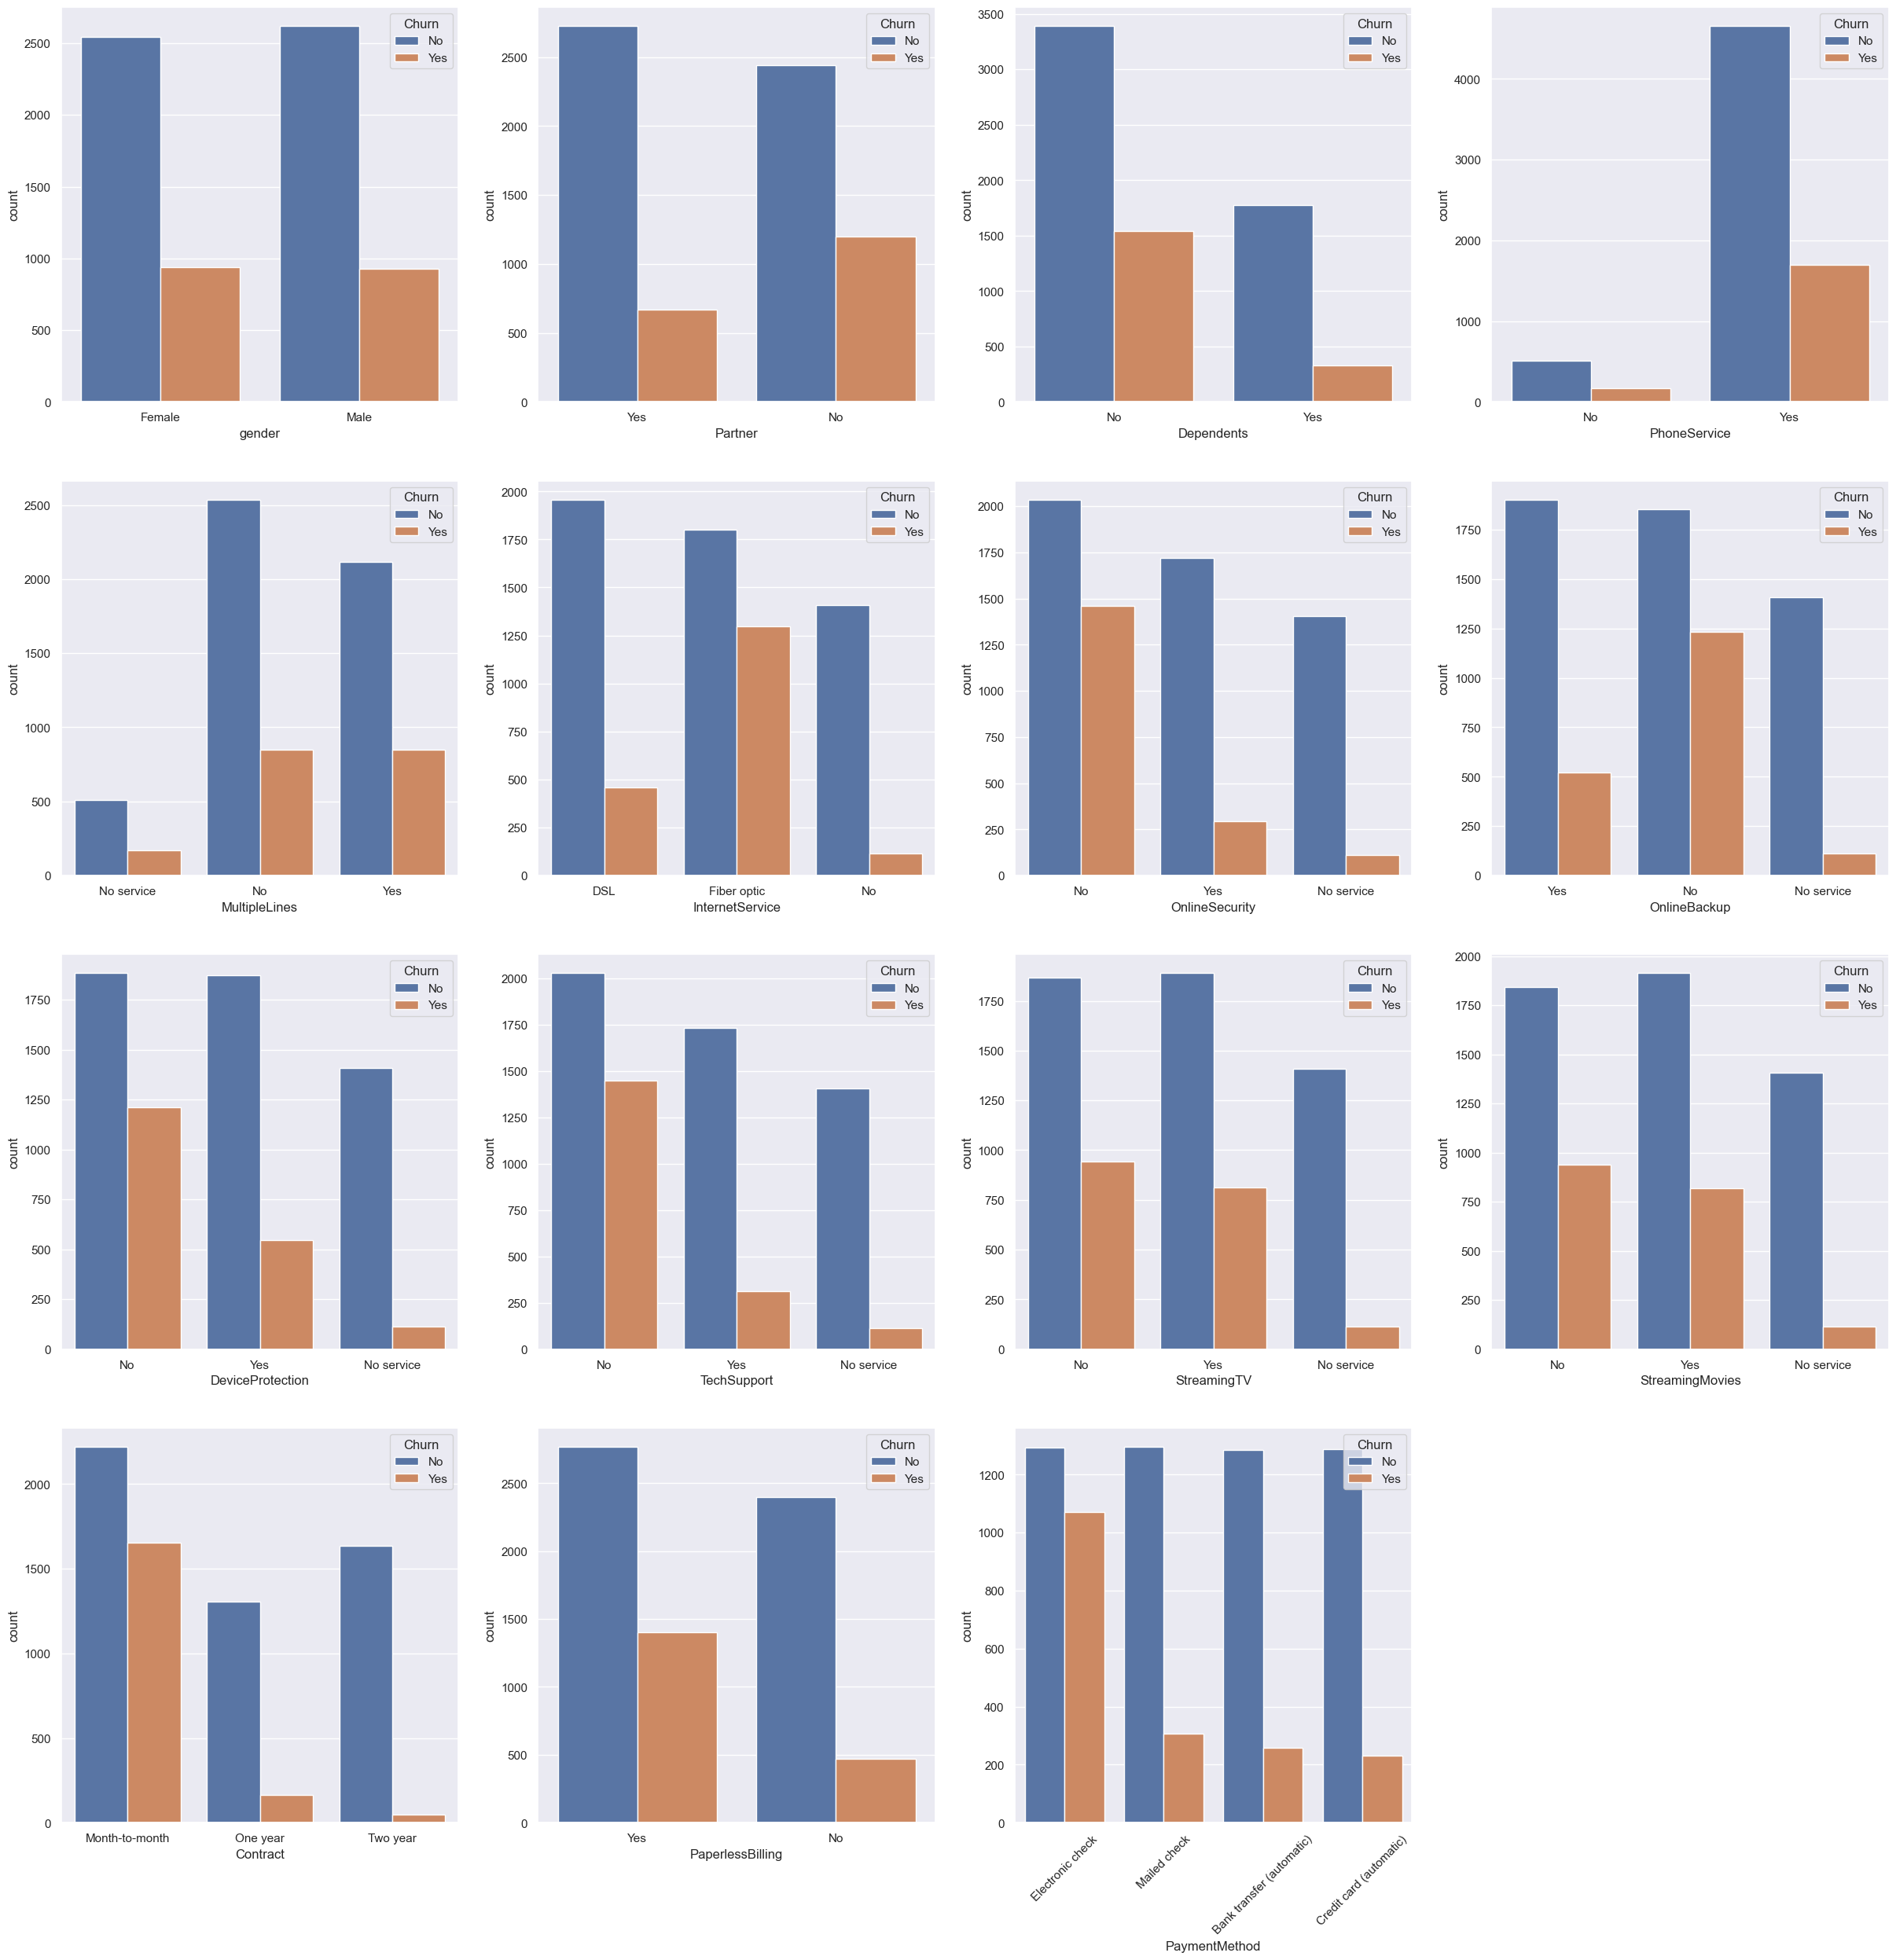

In [12]:
# Churn Distribution by Category
plt.figure(figsize=(30, 30))
for index, col in enumerate(categorical_columns):
    if col != 'Churn':
        plt.subplot(4, 4, index+1)
        sns.countplot(data=dataset, x=col, hue='Churn')
        if(len(dataset[col].unique()) > 3):
            plt.xticks(rotation=45)
plt.show()

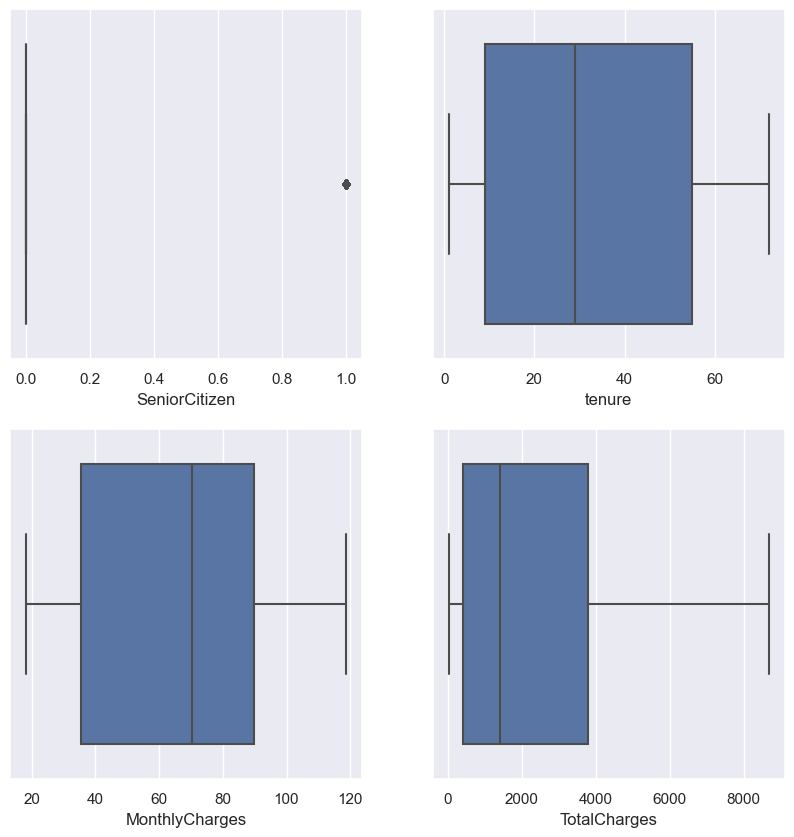

In [13]:
# Numerical Columns Distribution
plt.figure(figsize=(10, 10))
for index, col in enumerate(numerical_columns):
    plt.subplot(2, 2, index+1)
    sns.boxplot(data=dataset, x=col)
plt.show()

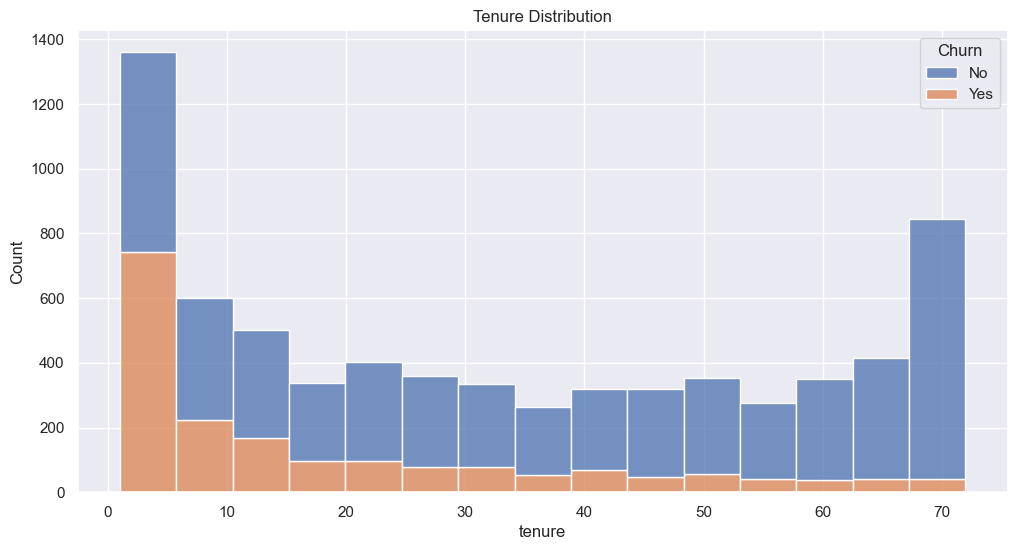

In [14]:
# Tenure Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='Tenure', hue='Churn', multiple='stack')
plt.title('Tenure Distribution')
plt.show()

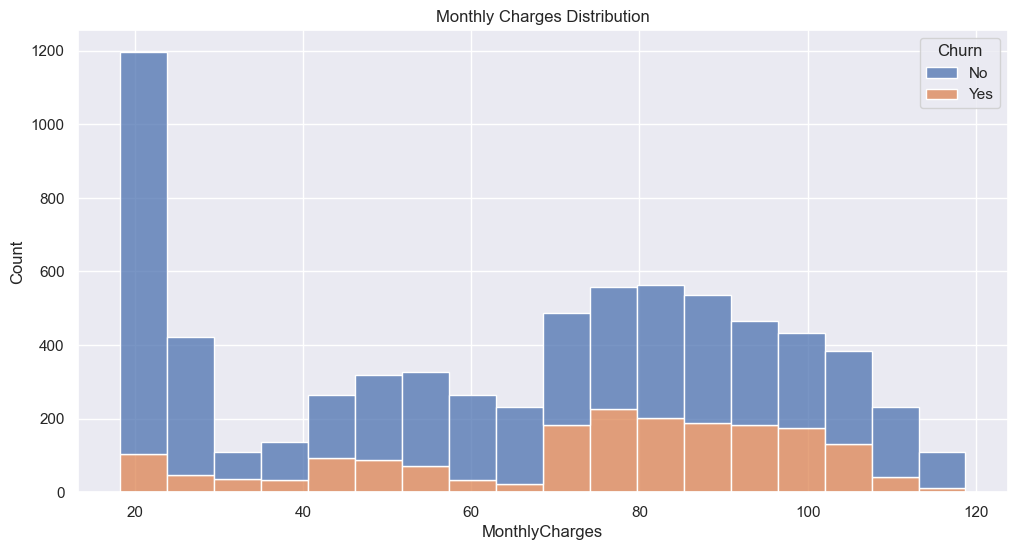

In [15]:
# Monthly Charges Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='MonthlyCharges', hue='Churn', multiple='stack')
plt.title('Monthly Charges Distribution')
plt.show()

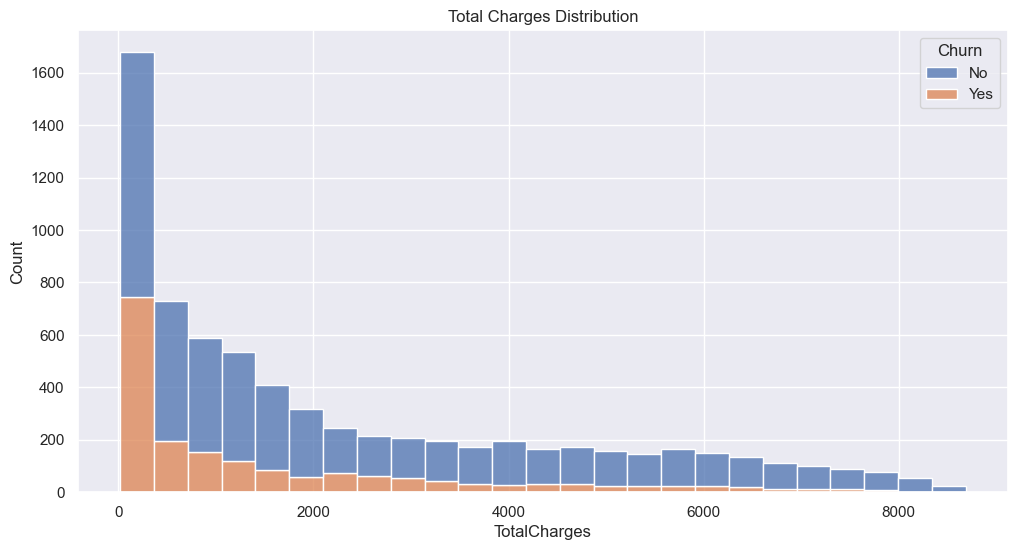

In [16]:
# Total Charges Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=dataset, x='TotalCharges', hue='Churn', multiple='stack')
plt.title('Total Charges Distribution')
plt.show()

In [17]:
# Extracting Unique Values for each Categorical Column
for col in categorical_columns:
    print(f'{col}: {dataset[col].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No service']
OnlineBackup: ['Yes' 'No' 'No service']
DeviceProtection: ['No' 'Yes' 'No service']
TechSupport: ['No' 'Yes' 'No service']
StreamingTV: ['No' 'Yes' 'No service']
StreamingMovies: ['No' 'Yes' 'No service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


### Ordinal Encoding

In [18]:
# Seperating Categorical Columns based on Mapping Values
categorical_columns_ordinal_1 = [
    'Partner',
    'Dependents',
    'PhoneService',
    'PaperlessBilling',
    'Churn'
]
categorical_columns_ordinal_2 = [
    'MultipleLines',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

In [19]:
# Mapping Values
ordinal_map_1 = {
    'Yes': 1,
    'No': 0
}
ordinal_map_2 = {
    'Yes': 1,
    'No': 0,
    'No service': -1
}
ordinal_map_3 = {
    'Fiber optic': 1,
    'DSL': 0,
    'No': -1
}
ordinal_map_4 = {
    'Two year': 2,
    'One year': 1,
    'Month-to-month': 0
}
ordinal_map_5 = {
    'Female': 1,
    'Male': 0
}

In [20]:
# Mapping Values for Different Categorical Columns 
for col in categorical_columns_ordinal_1:
    dataset[col] = dataset[col].map(ordinal_map_1)

for col in categorical_columns_ordinal_2:
    dataset[col] = dataset[col].map(ordinal_map_2)

dataset['Internet Service'] = dataset['Internet Service'].map(ordinal_map_3)
dataset['Contract'] = dataset['Contract'].map(ordinal_map_4)
dataset['Gender'] = dataset['Gender'].map(ordinal_map_5)

### Survival Analysis

In [21]:
# Kaplan Meier
km = KaplanMeierFitter()

tenure = dataset['Tenure']
churn = dataset['Churn']

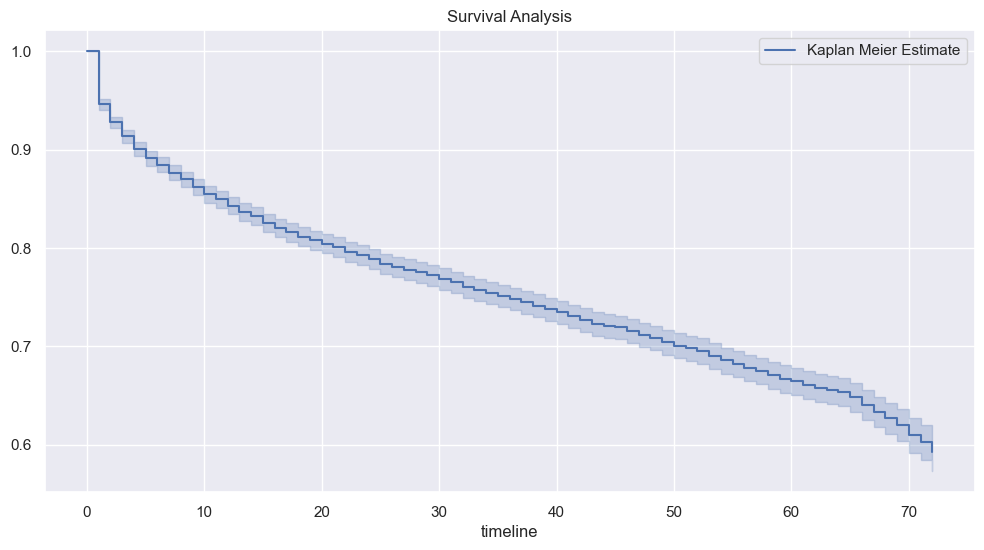

In [22]:
# Kaplan Meier Estimate
plt.figure(figsize=(12, 6))
km.fit(tenure, churn,label='Kaplan Meier Estimate')
km.plot_survival_function()
plt.title('Survival Analysis')
plt.show()

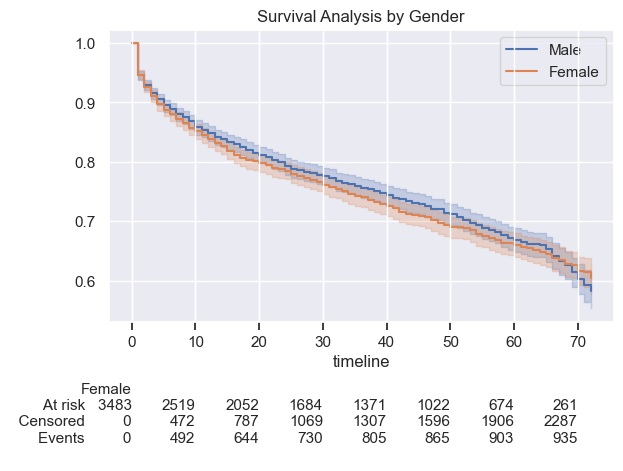

In [23]:
# Survival Analysis by Gender
ax = plt.subplot()
m = (dataset['Gender'] == 0)
km.fit(durations = tenure[m], event_observed = churn[m], label = "Male")
km.plot_survival_function(ax = ax)
km.fit(tenure[~m], event_observed = churn[~m], label = "Female")
km.plot_survival_function(ax = ax, at_risk_counts = True)
plt.title('Survival Analysis by Gender')
plt.show()

### Label Encoding 

In [24]:
# Using Pandas Library to Encode Payment Method Column
dataset = pd.get_dummies(dataset, columns=['Payment Method'], drop_first=True)

### Correlation Heatmap

In [25]:
# Correlation Matrix
correlation_matrix = dataset.corr()

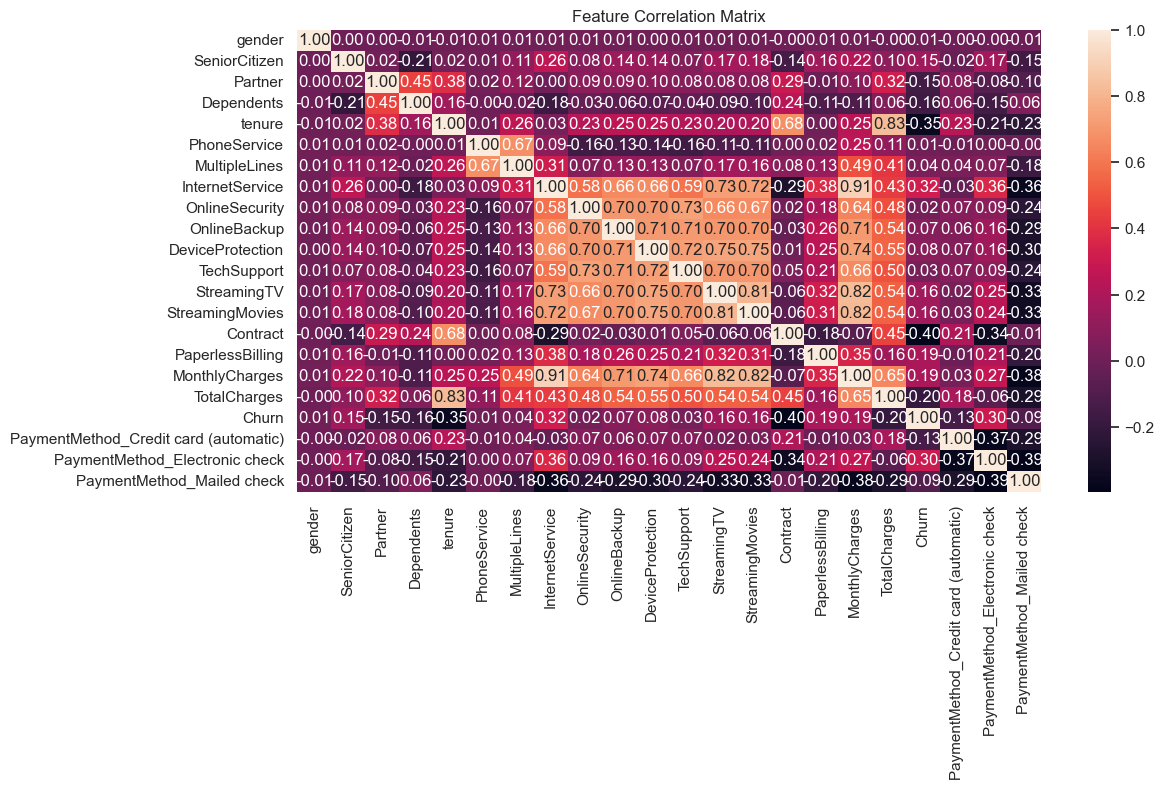

In [26]:
# Plotting Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

### Cox Proportional Hazard Model

In [27]:
cph = CoxPHFitter()
cph.fit(dataset, 'tenure', 'Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -12673.77
         time fit was run = 2024-04-25 20:27:07 UTC

---
                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                     
gender                                  0.03       1.04       0.05            -0.06             0.13                 0.94                 1.13
SeniorCitizen                           0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
Partner                                -0.18       0.83       0.06            -0.29            -0.08                 0.75                 0.93
Dependents                             -0.09       0.92       0.07            -0.22             0.05                 0.80                 1.05
PhoneService                            1.12       3.08       0.17             0.78             1.47                 2.19                 4.34
MultipleLines                           0.20       1.22       0.06             0.08             0.32                 1.09                 1.38
InternetService                         1.63       5.08       0.14             1.36             1.89                 3.89                 6.64
OnlineSecurity                         -0.07       0.93       0.06            -0.19             0.05                 0.83                 1.05
OnlineBackup                            0.08       1.08       0.05            -0.03             0.18                 0.97                 1.20
DeviceProtection                        0.23       1.25       0.06             0.12             0.34                 1.12                 1.40
TechSupport                             0.05       1.05       0.06            -0.07             0.18                 0.93                 1.19
StreamingTV                             0.54       1.71       0.08             0.39             0.69                 1.47                 1.98
StreamingMovies                         0.54       1.71       0.08             0.39             0.69                 1.48                 1.99
Contract                               -1.61       0.20       0.08            -1.77            -1.45                 0.17                 0.23
PaperlessBilling                        0.15       1.16       0.06             0.04             0.26                 1.04                 1.30
MonthlyCharges                         -0.01       0.99       0.01            -0.02            -0.00                 0.98                 1.00
TotalCharges                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
PaymentMethod_Credit card (automatic)  -0.01       0.99       0.09            -0.19             0.16                 0.83                 1.18
PaymentMethod_Electronic check          0.39       1.47       0.07             0.24             0.53                 1.28                 1.70
PaymentMethod_Mailed check              0.51       1.66       0.09             0.34             0.68                 1.40                 1.97

                                        cmp to      z      p   -log2(p)
covariate                                                              
gender                                    0.00   0.74   0.46       1.12
SeniorCitizen                             0.00   0.57   0.57       0.82
Partner                                   0.00  -3.34 <0.005      10.23
Dependents                                0.00  -1.25   0.21       2.25
PhoneService                              0.00   6.44 <0

### Extracting Variables

In [28]:
# Independent Variables
X = dataset.drop(columns=['Churn'], axis=1)

# Dependent Variable
y = dataset.loc[:, 'Churn']

### Splitting Data

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

### Feature Scaling

In [30]:
# Standard Scaler will Scale Values between -3 to +3
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

### GridSearchCV

In [31]:
# Models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'GaussianNB': GaussianNB(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Model Parameters
param_grids = {
    'RandomForestClassifier': {
        'n_estimators': [100, 300, 500, 800, 1000],
        'max_depth': [10, 20, 30, None]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    'DecisionTreeClassifier': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GaussianNB': {}
}

results = []

# Grid Search with Cross Validation
for key, value in models.items():
    grid_search = GridSearchCV(estimator=value, param_grid=param_grids[key],cv=10, n_jobs=-1, refit='accuracy', scoring=['accuracy', 'precision', 'recall'])
    grid_search.fit(X=X_train_scaled, y=y_train)
    print(f"Best parameters for {value}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")
    results.append({'model': value, 'params': grid_search.best_params_, 'accuracy': grid_search.best_score_})

grid_search_df = pd.DataFrame(results)

### GridSearch Results

In [32]:
results = pd.DataFrame(grid_search.cv_results_)
relevant_columns = ['params', 'mean_test_accuracy', 'std_test_accuracy', 'mean_test_precision', 'std_test_precision', 'mean_test_recall', 'std_test_recall']
results = results.loc[:, relevant_columns]

results

,params,mean_test_accuracy,std_test_accuracy,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall
0,"{'max_depth': 10, 'n_estimators': 100}",0.800889,0.011593,0.653024,0.035170,0.511933,0.029337
1,"{'max_depth': 10, 'n_estimators': 300}",0.801601,0.010678,0.657279,0.035178,0.507860,0.027698
2,"{'max_depth': 10, 'n_estimators': 500}",0.802312,0.012857,0.660438,0.039766,0.505801,0.026452
3,"{'max_depth': 10, 'n_estimators': 800}",0.800889,0.010831,0.656056,0.036071,0.505815,0.026749
4,"{'max_depth': 10, 'n_estimators': 1000}",0.800712,0.012561,0.656346,0.040105,0.503769,0.024497
5,"{'max_depth': 20, 'n_estimators': 100}",0.787559,0.015453,0.619179,0.037094,0.483319,0.037585
6,"{'max_depth': 20, 'n_estimators': 300}",0.790400,0.016606,0.628641,0.040522,0.482634,0.038800
7,"{'max_depth': 20, 'n_estimators': 500}",0.791466,0.018031,0.630349,0.043589,0.487396,0.043139
8,"{'max_depth': 20, 'n_estimators': 800}",0.791643,0.016300,0.630804,0.037950,0.486036,0.041061
9,"{'max_depth': 20, 'n_estimators': 1000}",0.789155,0.020305,0.624870,0.049456,0.481945,0.044520


In [33]:
best_score = grid_search.best_score_
best_params = grid_search.best_params_
model = grid_search.best_estimator_

print("Best Score:", best_score)
print("Best Parameters:", best_params)
print("Best Model:", model)

Best Score: 0.8023115870116243
Best Parameters: {'max_depth': 10, 'n_estimators': 500}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=500)


### Random Forest

In [34]:
# Fitting Model
model.fit(X_train_scaled, y_train)

# Making Prediction
y_pred = model.predict(X_test_scaled)

# Metrics
model_accuracy = accuracy_score(y_pred, y_test)
model_precision = precision_score(y_pred, y_test)
model_recall = recall_score(y_pred, y_test)
model_cm = confusion_matrix(y_pred, y_test)

### XGBoost

In [35]:
# Initialising Model
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=5,
    random_state=21
)

# Fitting Model
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Making Prediction
y_pred = xgb.predict(X_test_scaled)

# Metrics
xgb_accuracy = accuracy_score(y_pred, y_test)
xgb_precision = precision_score(y_pred, y_test)
xgb_recall = recall_score(y_pred, y_test)
xgb_cm = confusion_matrix(y_pred, y_test)

### Artificial Neural Network

In [36]:
# Initialising Model
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling Model
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting Model
ann.fit(X_train, y_train, epochs=50, batch_size=32)

# Making Prediction
y_pred = ann.predict(X_test) > 0.5

# Metrics
ann_accuracy = accuracy_score(y_pred, y_test)
ann_precision = precision_score(y_pred, y_test)
ann_recall = recall_score(y_pred, y_test)
ann_cm = confusion_matrix(y_pred, y_test)

Epoch 1/50
176/176 [==============================] - 0s 684us/step - loss: 1.6228 - accuracy: 0.7061
Epoch 2/50
176/176 [==============================] - 0s 630us/step - loss: 0.5977 - accuracy: 0.7604
Epoch 3/50
176/176 [==============================] - 0s 631us/step - loss: 0.5569 - accuracy: 0.7664
Epoch 4/50
176/176 [==============================] - 0s 624us/step - loss: 0.5366 - accuracy: 0.7717
Epoch 5/50
176/176 [==============================] - 0s 621us/step - loss: 0.5256 - accuracy: 0.7730
Epoch 6/50
176/176 [==============================] - 0s 617us/step - loss: 0.5188 - accuracy: 0.7781
Epoch 7/50
176/176 [==============================] - 0s 618us/step - loss: 0.5147 - accuracy: 0.7801
Epoch 8/50
176/176 [==============================] - 0s 613us/step - loss: 0.5109 - accuracy: 0.7808
Epoch 9/50
176/176 [==============================] - 0s 615us/step - loss: 0.5041 - accuracy: 0.7851
Epoch 10/50
176/176 [==============================] - 0s 702us/step - loss: 0.501

### Metrics Dataframe

In [37]:
metrics_df = pd.DataFrame([[model_accuracy, model_precision, model_recall, xgb_accuracy, xgb_precision, xgb_recall, ann_accuracy, ann_precision, ann_recall]], columns=['random_forest_accuracy', 'random_forest_precision', 'random_forest_recall', 'xgboost_accuracy', 'xgboost_precision', 'xgboost_recall', 'artificial_neural_network_accuracy', 'artificial_neural_network_precision', 'artificial_neural_network_recall'])

In [38]:
print(metrics_df)

   random_forest_accuracy  random_forest_precision  random_forest_recall  \
0                0.791045                   0.5125              0.674342   

   xgboost_accuracy  xgboost_precision  xgboost_recall  \
0          0.771855               0.26        0.806202   

   artificial_neural_network_accuracy  artificial_neural_network_precision  \
0                            0.781095                               0.3825   

   artificial_neural_network_recall  
0                          0.714953  


### Confusion Matrix

In [39]:
print('Random Forest:', model_cm)
print('XGBoost:', xgb_cm)
print('Artificial Neural Network:', ann_cm)

Random Forest: [[908 195]
 [ 99 205]]
XGBoost: [[982 296]
 [ 25 104]]
Artificial Neural Network: [[946 247]
 [ 61 153]]


### LIME(Local Interpretable Model-agnostic Explanations)

In [40]:
# Initialising Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    mode='classification'
)

In [41]:
# Plotting Explainer
exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=model.predict_proba
)
exp.show_in_notebook(show_table=True)